In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
import math
import utils

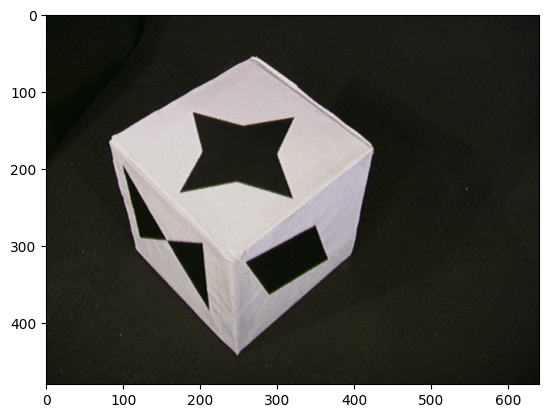

In [2]:
im = cv2.imread("week06_data/Box3.bmp")
im = im[:,:,::-1]
plt.imshow(im)

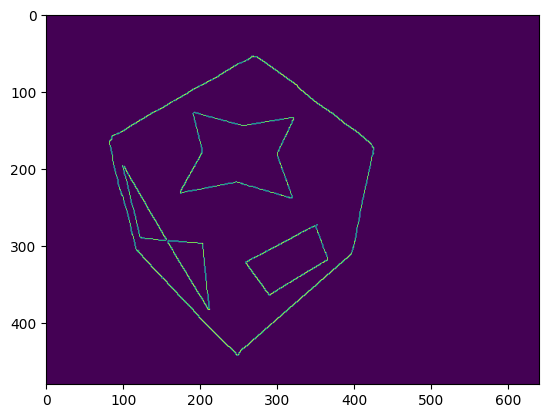

In [3]:
edges = cv2.Canny(im, 100, 500)
plt.imshow(edges)

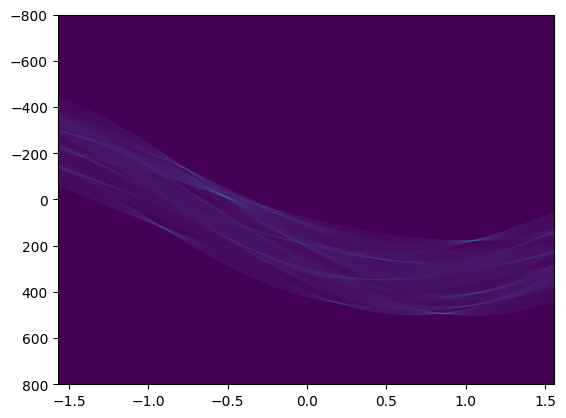

In [4]:
hspace, angles, dists = skimage.transform.hough_line(edges)
extent = [angles[0], angles[-1], dists[-1], dists[0]]
plt.imshow(hspace, extent=extent, aspect='auto')

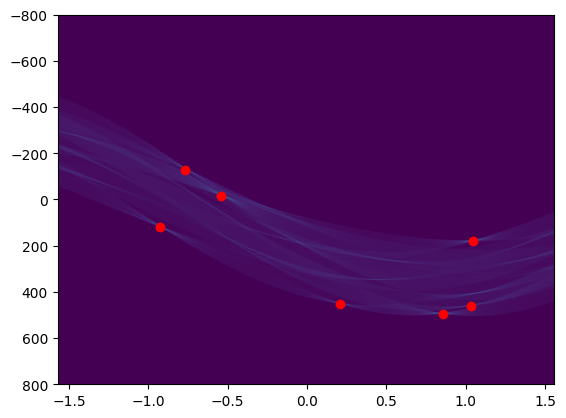

In [5]:
extH, extAngles, extDists = skimage.transform.hough_line_peaks(hspace, angles, dists, num_peaks=15)
plt.imshow(hspace, extent=extent, aspect='auto')
plt.scatter(extAngles, extDists, color='red', marker='o')

In [6]:
def DrawLine(l, shape):
    #Checks where the line intersects the four sides of the image
    # and finds the two intersections that are within the frame
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2]/q[2]
        if all(q>=0) and all(q+1<=shape[1::-1]):
            return q
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    if (len(P)==0):
        print("Line is completely outside image")
    plt.plot(*np.array(P).T)

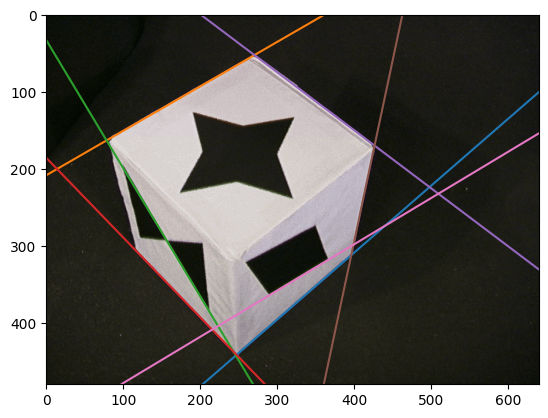

In [7]:
plt.imshow(im)
for phi, r in zip(extAngles, extDists):
    a = math.cos(phi) # math.tan(phi)
    b = math.sin(phi) # - 1
    c = -r # r / math.sin(phi)
    l = np.array([a, b, c])
    DrawLine(l, im.shape)

RANSAC

In [8]:
def test_points(n_in, n_out):
    a = (np.random.rand(n_in)-.5)*10
    b = np.vstack((a, a*.5+np.random.randn(n_in)*.25))
    points = np.hstack((b, 2*np.random.randn(2, n_out)))
    return np.random.permutation(points.T).T

In [15]:
def fitline(p1, p2):
    l = np.cross(p1, p2)
    return l / math.sqrt(l[0]**2 + l[1]**2)

def get_inliers(ps, l, t):
    inliers = []
    phom = utils.PiInv(ps)
    for i in range(phom.shape[1]):
        if abs(np.dot(l, phom[:,i])) < t: inliers.append(phom[:,i])
    return utils.Pi(np.vstack(inliers).T)

def sample(points):
    indices = np.random.choice(points.shape[1], size=2, replace=False)
    return points[:, indices]

In [31]:
def ransac(points, p, t):
    best_inl = None
    best_l = None
    eps = None
    Ncap = math.inf
    N = 0
    while Ncap > N:
        ps = utils.PiInv(sample(points))
        l = fitline(ps[:,0], ps[:,1])
        inliers = get_inliers(points, l, t)
        if best_inl is None or inliers.shape[1] > best_inl.shape[1]:
            best_inl = inliers
            best_l = l
            eps = 1 - inliers.shape[1]/points.shape[1]
        Ncap = math.log(1 - p) / math.log((1 - (1 - eps)**2))
        N += 1
    print(f'Best line found: {best_l}')
    print(f'with num of inliers: {best_inl.shape[1]}')
    print(f'and num of iterations: {N}')
    return best_l, best_inl

In [17]:
def plotLine(l):
    x_values = np.linspace(-10, 10, 100)
    y_values = (-l[2] - l[0]*x_values) / l[1]
    plt.plot(x_values, y_values, label='Line')

In [12]:
points = test_points(14, 6)

Best line found: [-0.42211332  0.90654308 -0.02132412]
with num of inliers: 16
and num of iterations: 5


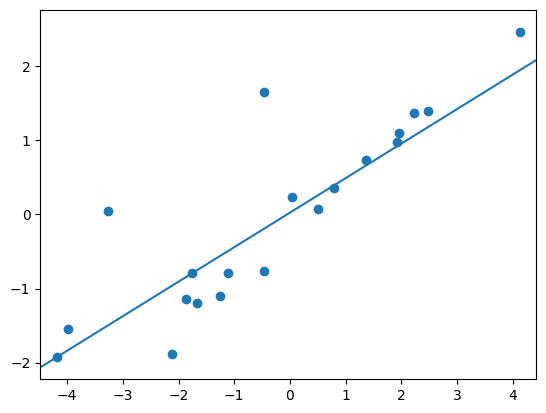

In [32]:
l, inl = ransac(points, 0.99, 0.5)

plt.scatter(points[0], points[1])
border = 0.3
plt.xlim(min(points[0]) - border, max(points[0]) + border)
plt.ylim(min(points[1]) - border, max(points[1]) + border)
plotLine(l)

In [14]:
def pca_line(x): # assumes x is a (2 x n) array of points
    d = np.cov(x)[:, 0]
    d /= np.linalg.norm(d)
    l = [d[1], -d[0]]
    l.append(-(l@x.mean(1)))
    return l

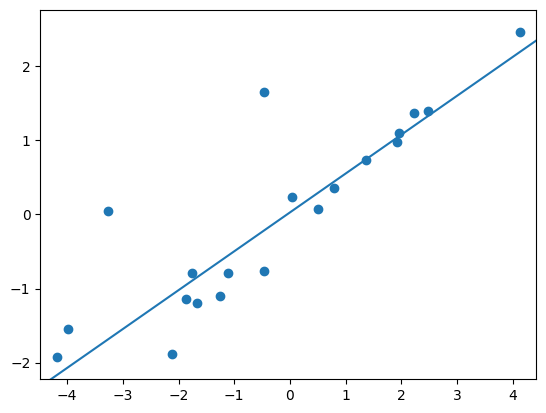

In [33]:
plt.scatter(points[0], points[1])
border = 0.3
plt.xlim(min(points[0]) - border, max(points[0]) + border)
plt.ylim(min(points[1]) - border, max(points[1]) + border)
plotLine(pca_line(inl))